**Install missing packages**

Some required packages are not installed by default in Google Colab. It is necessary to manually install them for each user session.


In [1]:
!pip install utils
!pip install split-folders tqdm

**Setup the environment and variables**

The following steps are done

1.   Import all the necessary modules
2.   Set the random number seed. This is required for reproducing the results every time.
3. Set the global variables 



In [203]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import utils as utils
import time
import math
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import gdown
import splitfolders
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import glob
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc

# Set the random number seed. This allows results to be reproduced
seed = 1619
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

# Hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.0001
NUM_EPOCHS = 25

# Global variables
DATASET_URL = 'https://drive.google.com/uc?id=1ZrnMdjrJAyJwdsH1L2W6pmL8hjFFuhqw'
DATA_PATH = "/content/data_split/"
UNZIP_LOC = '/content/data/'
ZIPFILE = 'dataset.zip'
MODEL_ROOT = '/content/models/'
MODEL_NAME= 'CovidCNN'
MODEL_PATH = MODEL_ROOT + '/' + MODEL_NAME + '/' + datetime.today().strftime('%m-%d-%Y') + '/'

# Flag to check if GPU is available for use.
use_gpu = torch.cuda.is_available()

# Location for storing best model and checkpoints
if not os.path.exists(MODEL_PATH):
   os.makedirs(MODEL_PATH, exist_ok=True)


**Download dataset**

The dataset is stored in Google Drive as a zip file. The following code downloads the zip file to the Colab workspace and then unzips it.

The dataset contains 7200 Chest X Rays in total. This is a balanced dataset with 3600 COVID XRays and 3600 non-COVID XRays.

In [3]:
# Remove existing dataset files to avoid conflicts
!rm -rf "{UNZIP_LOC}"
!rm -rf "{DATA_PATH}"
!rm "{ZIPFILE}"

# Download from Google drive to Colab
gdown.download(DATASET_URL, ZIPFILE, quiet=False)

# Unzip the file in the Colab workspace
!unzip -q "{ZIPFILE}" -d "{UNZIP_LOC}"

rm: cannot remove 'dataset.zip': No such file or directory


Downloading...
From: https://drive.google.com/uc?id=1ZrnMdjrJAyJwdsH1L2W6pmL8hjFFuhqw
To: /content/dataset.zip
1.56GB [00:19, 80.1MB/s]


Validate the dataset image count 

In [ ]:
## <TODO> Uncomment after correcting size of dataset
# assert len(os.listdir(UNZIP_LOC + 'COVID')) == 3600, "COVID Xray count wrong. Imbalanced dataset"
# assert len(os.listdir(UNZIP_LOC + 'Non-COVID')) == 3600, "Non-COVID Xray count wrong. Imbalanced dataset"

**Dataset split**

The dataset needs to be split for training, test and validation. This train/test/validation ratio is 60% : 20% : 20%.

In [4]:
splitfolders.ratio(UNZIP_LOC, output= DATA_PATH, seed=seed, ratio=(0.6,0.2,0.2))

Copying files: 7232 files [00:07, 1022.33 files/s]


Validate that the count of files after the dataset split is unchanged.

In [5]:
total_files = sum([len(files) for _, _, files in os.walk(UNZIP_LOC)])
total_split_files = sum([len(files) for _, _, files in os.walk(DATA_PATH)])

assert total_files == total_split_files, "XRay count after the dataset split is wrong."

Image Pre-processing

In [151]:

def get_XRay_count(folder, data_path=DATA_PATH):

    covid_path = data_path + folder + '/COVID' 
    non_covid_path = data_path + folder + '/Non-COVID'

    covid_count = (len(os.listdir(covid_path)))
    non_covid_count = (len(os.listdir(non_covid_path)))

    return covid_count, non_covid_count

def load_data(data_path=DATA_PATH):

    transformed_img = transforms.Compose([
        transforms.RandomResizedCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    train_path = DATA_PATH + '/train' 
    train_data = datasets.ImageFolder(root=train_path, 
                                      transform=transformed_img)
    train_loader = torch.utils.data.DataLoader(train_data,batch_size=BATCH_SIZE,shuffle= True)

    val_path = DATA_PATH + '/val' 
    val_data = datasets.ImageFolder(root=val_path, 
                                    transform=transformed_img)
    val_loader = torch.utils.data.DataLoader(val_data,batch_size=BATCH_SIZE,shuffle= False)
    
    test_path = DATA_PATH + '/test' 
    test_data = datasets.ImageFolder(root=test_path, 
                                    transform=transformed_img)
    test_loader = torch.utils.data.DataLoader(test_data, 
                                             batch_size=BATCH_SIZE,shuffle = False)    
    
    return train_loader, val_loader, test_loader

Validate that the count of XRays in the train/val/test folders is as per the dataset split ratio.

In [152]:
# Call the function to load the train, test and validation dataloaders from the dataset.
train_loader, val_loader, test_loader = load_data()

assert type(train_loader) is torch.utils.data.dataloader.DataLoader

## <TODO> Uncomment after correcting size of dataset
# # Validate the number of entries in train, test and val folders
# assert get_XRay_count('train') == (2160, 2160), "train folder XRay count is wrong"
# assert get_XRay_count('val') == (720, 720), "val folder XRay count is wrong"
# assert get_XRay_count('test') == (720, 720), "test folder XRay count is wrong"

# # Validate the length of the dataloaders
# assert len(train_loader) == math.ceil(4320/BATCH_SIZE), "Train dataloader length is wrong"
# assert len(val_loader) == math.ceil(1440/BATCH_SIZE), "Val dataloader length is wrong"
# assert len(test_loader) == math.ceil(1440/BATCH_SIZE), "Test dataloader length is wrong"

# # Find the values assigned to the labels by the DataLoader
# train_loader.class_to_idx

In [13]:
# train_loader, val_loader, test_loader = load_data()   

# # images, labels = next(iter(train_loader))
# # print (images, labels)

# '''
# Check which label has been assigned to what
# '''
# train_loader.class_to_idx

Show some sample images from the dataloader.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


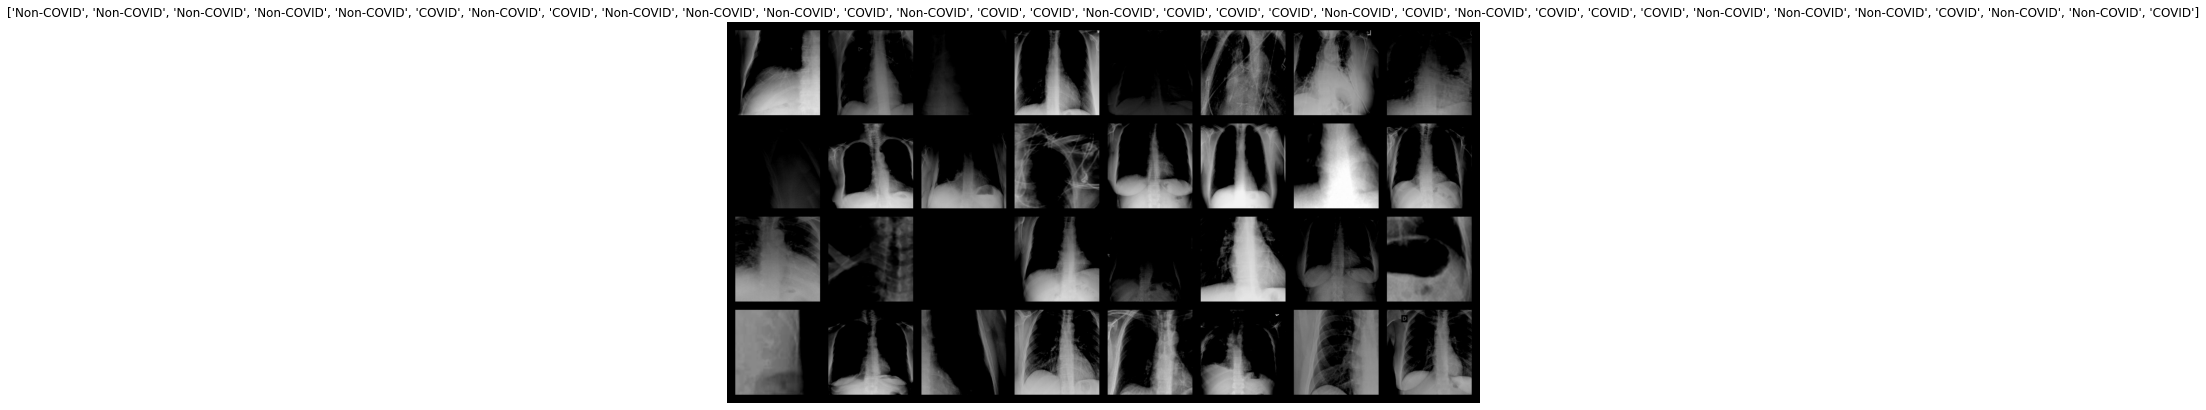

In [153]:
def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(15, 7))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images, padding=25)
    imshow(img, title=["COVID" if x==0  else "Non-COVID" for x in labels])

show_batch_images(train_loader)

In [51]:
from fastai.vision import *

# **Model Definition**

In the paper titled [A Deep Learning Approach to Detect COVID-19 Patients from Chest X-ray Images](https://www.researchgate.net/publication/344340531_A_Deep_Learning_Approach_to_Detect_COVID-19_Patients_from_Chest_X-ray_Images), Haque et al. proposed a model that uses Convolutional Neural Networks (CNNs) to predict COVID-19 patients using Chest X-Rays(CXRs).

The model has four 2D convolutional layers that have a kernel size of 3 x 3 and employs the Rectified Linear Unit (ReLU) activation function. Convolution layers 2, 3 and 4 have a Max. pooling layer of kernel size 2 x 2 to avoid overfitting. At the last convolutional layer, the output is flattened to a 1D vector and fed to a Fully Connected(FC) layer.  A Sigmoid activation function in the FC layer makes the classification. The architecture diagram is given below.

![CNN](https://www.researchgate.net/profile/Khandaker-Haque-2/publication/344340531/figure/fig4/AS:938577072513024@1600785620239/Workflow-diagram-of-the-proposed-CNN-model-for-COVID-19-detection.jpg)


In [200]:
class DarkNet(nn.Module):
    def __init__(self):
        super(DarkNet, self).__init__()

        self.pooling = nn.MaxPool2d(2, stride=2)

        self.convblock1 = nn.Sequential( 
            nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = (3,3), stride=(1,1), padding=1, bias = False),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            
        )
                 
        self.convblock2 = nn.Sequential( 
            nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3,3), stride=(1,1), padding=1, bias = False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            
        )
        

        self.tripleconv1 = nn.Sequential(nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), stride=(1,1), padding=1, bias = False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)),
            
            nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 16, kernel_size = (1,1), stride=(1,1), padding=0, bias = False),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(negative_slope=0.1, inplace=True)),
            
            nn.Sequential(
            nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3,3), stride=(1,1), padding=1, bias = False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.1, inplace=True))
            
        )

        self.tripleconv2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3,3), stride=(1,1), padding=1, bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            

            nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = (1,1), stride=(1,1), padding=0, bias = False),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            

            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3,3), stride=(1,1), padding=1, bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            
        )

        self.tripleconv3 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3,3), stride=(1,1), padding=1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            

            nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = (1,1), stride=(1,1), padding=0, bias = False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            

            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3,3), stride=(1,1), padding=1, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            
        )

        self.tripleconv4 = nn.Sequential(
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3,3), stride=(1,1), padding=1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            

            nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = (1,1), stride=(1,1), padding=0, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            

            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3,3), stride=(1,1), padding=1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            
        )

        self.convblock3 = nn.Sequential( 
            nn.Conv2d(in_channels = 256, out_channels = 128, kernel_size = (1,1), stride=(1,1), padding=0, bias = False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            
        )
                 
        self.convblock4 = nn.Sequential( 
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = (3,3), stride=(1,1), padding=1, bias = False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            
        )

        self.convblock5 = nn.Sequential( 
            nn.Conv2d(in_channels = 256, out_channels = 2, kernel_size = 1, stride=(1,1), bias = True),
            nn.BatchNorm2d(2),
            nn.ReLU()
            
        )

        # self.convblock5 = conv_layer(256,2)
        
        self.fc = nn.Linear(in_features = 128, out_features = 2)
            
        

    def forward(self, x):
        x = self.convblock1(x)
        x = self.pooling(x)
        # print (x.shape)
        x = self.convblock2(x)
        x = self.pooling(x)
        # print (x.shape)
        x = self.tripleconv1(x)
        # print ("after triple conv1")
        # print (x.shape)
        x = self.pooling(x)
        
        x = self.tripleconv2(x)
        x = self.pooling(x)
        # print ("after triple conv2")
        # print (x.shape)
        x = self.tripleconv3(x)
        x = self.pooling(x)
        # print ("after triple conv3")
        # print (x.shape)
        x = self.tripleconv4(x)
        # print ("after triple conv4")
        # print (x.shape)
        x = self.convblock3(x)
        
        x = self.convblock4(x)
        
        x = self.convblock5(x)
        # print ("after conv5")
        # print (x.shape)
        x = x.view(-1, 128)
        x = self.fc(x)
        # print ("returning x")
        return x


Validations

**Loss function and Optimizer**

The Cross Entropy loss function is used along with the Adam optimzer.

In [201]:
model = DarkNet()

criterion = None
optimizer = None

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

if use_gpu:
    model.cuda()
    criterion = criterion.cuda()


**Training**

The model training consists of the following steps in each epoch:

1.   In the training mode, run the training steps for each batch within the training dataloader.
2.   In evaludation model, validate the the model trained till then for each batch within the validation dataloader.
3.   Calculate validation accuracy. If validation accuracy is more than the best validation accuracy till then,

  *   Save the current model as the best model yet.
  *   Update best validation accuracy to current validation accuracy.

4.   Save model state as a checkpoint to resume training later in case of failure.    

At the end of training, the best model based on validaton accuracy is retrieved and returned.





In [206]:
def save_checkpoint(model_state, checkpoint_path):
  torch.save(model_state, checkpoint_path)

def plot_metrics(train_losses, train_accuracy, val_losses, val_accuracy):

  epoch_list=  list(range(1, NUM_EPOCHS+1))

  sns.set_style("darkgrid")
  plt.plot(epoch_list, val_losses, label='Validation Loss')
  plt.plot(epoch_list, val_accuracy, label='Validation Accuracy')
  plt.title('Accuracy/Training Loss over epochs')
  plt.ylabel('Accuracy/Loss')
  plt.xlabel('Epoch')
  plt.ylim([0, 1])
  plt.legend(['Validation Loss', 'Validation Accuracy'], loc='lower right')
  plt.show()

def train_model(model, train_dataloader, val_dataloader, n_epoch=NUM_EPOCHS, optimizer=optimizer, criterion=criterion):

    model.train() # prep model for training
    
    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []
    min_val_accuracy = 0.0
    file_path=''
    
    tb = SummaryWriter()

    for epoch in range(n_epoch):

      running_train_loss = 0
      running_val_loss = 0
      running_train_correct = 0
      running_val_correct = 0

      # Training loop
      for images, labels in train_dataloader:

        if use_gpu:
            images, labels = images.cuda(), labels.cuda()

        # Clear parameter gradients
        optimizer.zero_grad()
        # print ("images")
        # print (labels.shape)
        # forward pass
        outputs = model(images)
        # print (outputs.shape)
        #Calculate loss
        loss = criterion(outputs, labels)

        # Loss for batch
        running_train_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)

        # backward pass
        loss.backward()
        
        #Perform single optimization step
        optimizer.step()

        # Correct predictions
        running_train_correct += (preds == labels).sum().item()
        

      # Validation loop
      for images, labels in val_dataloader:
        if use_gpu:
            images, labels = images.cuda(), labels.cuda()
        
        # Eval mode
        model.eval()
        
        output = model(images)
        loss = criterion(output, labels)
        _, preds = torch.max(output, 1)

        # Calculate validation loss and correct predictions
        running_val_loss += loss.item() * images.size(0)
        running_val_correct += (preds == labels).sum().item()
      
      # Put back in train mode for next epoch
      model.train()
  
      # Calculate loss and accuracy for training and validation
      epoch_train_loss = running_train_loss / len(train_dataloader.dataset)
      epoch_train_accuracy = running_train_correct / len(train_dataloader.dataset)
      epoch_val_loss = running_val_loss / len(val_dataloader.dataset)
      epoch_val_accuracy = running_val_correct / len(val_dataloader.dataset)

      print(
          f"Epoch {epoch+1}, Train loss : {epoch_train_loss:.4f}, Training accuracy: {epoch_train_accuracy:.4f}, "
          f"Validation loss :{epoch_val_loss:.4f}, Validation accuracy: {epoch_val_accuracy:.4f}"
          )
      
      # Arrays having values from all epochs for plotting graphs
      train_losses.append(epoch_train_loss)
      train_accuracy.append(epoch_train_accuracy)
      val_losses.append(epoch_val_loss)
      val_accuracy.append(epoch_val_accuracy)

      # Save the checkpoint after every epoch so that if needed, training can be resumed from this point later on
      checkpoint_path = MODEL_PATH + 'last_model_state.pth'
      save_checkpoint({
          'epoch': epoch,
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict(),
          'loss': criterion,
          'epoch_val_accuracy': epoch_val_accuracy
      }, checkpoint_path)
      
      # If validation accuracy improves, save it so that he best model can be picked up at the end
      if epoch_val_accuracy > min_val_accuracy:
          print(f"Validation accuracy increased from {min_val_accuracy} -> {epoch_val_accuracy}. Saving model...")
          min_val_accuracy = epoch_val_accuracy
          file_path = MODEL_PATH + 'best_model_epoch' + str(epoch+1) + "_accuracy" + str(epoch_val_accuracy) + '.pth'
          torch.save(copy.deepcopy(model.state_dict()), file_path)

      # Remove previously saved models except the last checkpoint and best model
      for fpath in glob.glob(MODEL_PATH + '*.*') :
        if fpath not in [file_path,checkpoint_path]:
          os.remove(fpath)

      # Log the epoch loss and accuracy for validation using TensorBoard
      tb.add_scalar('Validation Loss', epoch_val_loss, epoch)
      tb.add_scalar('Validation Accuracy', epoch_val_accuracy, epoch)

    # Retrieve best model
    model = DarkNet()
    if use_gpu:
      model.cuda()
    model.load_state_dict(torch.load(file_path))
    
    return model, train_losses, train_accuracy, val_losses, val_accuracy


Traing the model and plotting accuracy

In [ ]:
# train_loader, val_loader, test_loader = load_data()

# # Load Tensorboard for live visualizations
# %load_ext tensorboard
# %tensorboard --logdir runs

# Train the model
model, train_losses, train_accuracy, val_losses, val_accuracy = train_model(model, train_loader, val_loader)

# Plot various metrics
plot_metrics(train_losses, train_accuracy, val_losses, val_accuracy)

Epoch 1, Train loss : 0.1203, Training accuracy: 0.9569, Validation loss :0.0993, Validation accuracy: 0.9633
Validation accuracy increased from 0.0 -> 0.9633471645919779. Saving model...
Epoch 2, Train loss : 0.1068, Training accuracy: 0.9617, Validation loss :0.0890, Validation accuracy: 0.9703
Validation accuracy increased from 0.9633471645919779 -> 0.9702627939142462. Saving model...
Epoch 3, Train loss : 0.0919, Training accuracy: 0.9693, Validation loss :0.4962, Validation accuracy: 0.8064
Epoch 4, Train loss : 0.0816, Training accuracy: 0.9682, Validation loss :0.2990, Validation accuracy: 0.8728
Epoch 5, Train loss : 0.0768, Training accuracy: 0.9740, Validation loss :0.2157, Validation accuracy: 0.9066
Epoch 6, Train loss : 0.0576, Training accuracy: 0.9809, Validation loss :0.3776, Validation accuracy: 0.8534
Epoch 7, Train loss : 0.0638, Training accuracy: 0.9735, Validation loss :0.0732, Validation accuracy: 0.9716
Validation accuracy increased from 0.9702627939142462 -> 0.

**Testing the model**

On the trained model, run the testing dataset and return the predictions along with the ground truths.

In [ ]:
def eval_model(model, dataloader):

  model.eval()

  Y_pred = []
  Y_test = []

  with torch.no_grad():
      for images, labels in dataloader:
          if use_gpu:
            images, labels = images.cuda(), labels.cuda()
          y_pred = model(images)
          _, y_pred_tag = torch.max(y_pred, 1)

          Y_pred = np.append(Y_pred,y_pred_tag.cpu().detach().numpy())
          Y_test = np.append(Y_test,labels.cpu().numpy())

  return Y_pred, Y_test

Load saved model for evaluation if required

In [ ]:
# model = get_model(MODEL_NAME)
# model.load_state_dict(torch.load('CovidCNN_0.95.pth'))
# model.eval()

**Testing the model and calculating performance metrics**



Accuracy: 0.6666666666666666 
Precision: 0.6753246753246753 
Recall: 0.6666666666666667 
F1: 0.6625000000000001 
Support: None


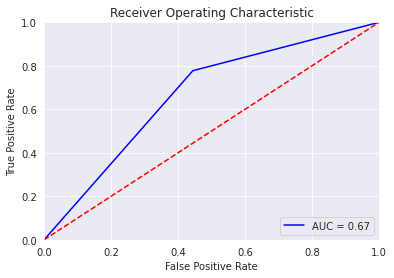

[[5 4]
 [2 7]]


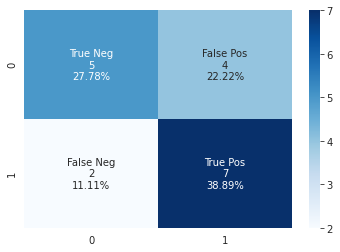

In [ ]:
  y_pred, y_true = eval_model(model, test_loader)

  # Print metrics
  accuracy = accuracy_score(y_true, y_pred)
  precision, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred
                                                                       , average='macro'
                                                                      )
  print(f"Accuracy: {accuracy} \nPrecision: {precision} \nRecall: {recall} \nF1: {fscore} \nSupport: {support}")


  #ROC curve
  fpr, tpr, threshold = roc_curve(y_true, y_pred)
  
  # AUC
  roc_auc = auc(fpr, tpr)

  plt.title('Receiver Operating Characteristic')
  plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
  plt.legend(loc = 'lower right')
  plt.plot([0, 1], [0, 1],'r--')
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.show() 

  # Show confusion matrix
  np.set_printoptions(threshold=np.inf) 
  cm1 = confusion_matrix(y_true, y_pred)
  print(cm1)

  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cm1.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cm1.flatten()/np.sum(cm1)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cm1, annot=labels, fmt='', cmap='Blues')



Save the final model for later use

In [ ]:

model_filename = MODEL_NAME + '_' + str(accuracy)+ '.pth'
torch.save(model.state_dict(), model_filename)

# download checkpoint file
files.download(model_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>